## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Lecture 5: Debugging a Machine Learning Model

This notebook provides a basic introduction to three practical model debugging techniques that can be applied to machine learning models: residual analysis, sensitivity analysis, and benchmark models. The notebook starts by loading the UCI credit card default dataset and using h2o to train a GBM model to predict credit card defaults. Then, residual analysis is used to discover and debug an issue with the GBM, and the GBM is retrained and improved. Sensitivity analysis is then conducted to test the GBM credit card default model for fairness and stability. The notebook closes by comparing the GBM predictions to a benchmark linear model's predictions.  

#### Global hyperparameters

In [1]:
SEED = 12345

#### Python imports and inits

In [2]:
from rmltk import explain, model # simple module for explaining and training models

# h2o Python API and specific classes for gbm
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
import shap          # for visualizing Shapley values


pd.options.display.max_columns = 999 # enable display of all columns in notebook

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends
import seaborn as sns

# display plots in notebook
%matplotlib inline

h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

/home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_252"; OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09); OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
  Starting server from /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfp1yr6sh
  JVM stdout: /tmp/tmpfp1yr6sh/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpfp1yr6sh/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,9 months and 25 days !!!
H2O cluster name:,H2O_from_python_patrickh_02yx74
H2O cluster total nodes:,1
H2O cluster free memory:,1.879 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

**Also, best practices and regulations can prohibit the use of demographic variables in credit lending models. This notebook uses them in the model only for educational purposes!**

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y_name = 'DEFAULT_NEXT_MONTH'
x_names = [name for name in data.columns if name not in [y_name, 'ID']]
print('y_name =', y_name)
print('x_name =', x_names)

y_name = DEFAULT_NEXT_MONTH
x_name = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable
In h2o, a numeric variable can be treated as numeric or categorical. The target variable `DEFAULT_NEXT_MONTH` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [6]:
data[y_name] = data[y_name].asfactor() 

#### Display descriptive statistics

In [7]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping

In [8]:
# split into training and validation
train, valid = data.split_frame([0.7], seed=SEED)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 21060, columns = 25
Validation data rows = 8940, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here.

In [9]:
# initialize GBM model
gbm = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                   max_depth=4,           # trees can have maximum depth of 4
                                   sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                   col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                   stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                   seed=SEED)            # for reproducibility

# train a GBM model
gbm.train(y=y_name, x=x_names, training_frame=train, validation_frame=valid)

# print AUC
print('GBM Validation AUC = %.4f' % gbm.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Validation AUC = 0.7804


#### Display Shapley variable importance

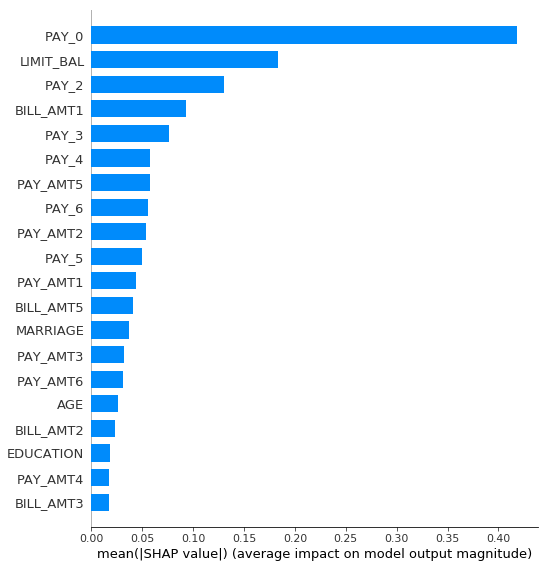

In [11]:
shap_contribs_hf = gbm.predict_contributions(valid)
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar')

`PAY_0` is by far the most important variable in the model. Perhaps too important, as will be demonstrated below.

## 3. Conduct Residual Analysis to Debug Model
Residuals refer to the difference between the recorded value of a dependent variable and the predicted value of a dependent variable for every row in a data set. Plotting the residual values against the predicted values is a time-honored model assessment technique and a great way to see all your modeling results in two dimensions.

#### Bind model predictions onto validation data 
To calculate the residuals for our GBM model, first the model predictions are merged onto the validation set. The validation data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing residuals for the training inputs and predictions.

In [12]:
yhat_name = 'p_DEFAULT_NEXT_MONTH'
preds1 = gbm.predict(valid).drop(['predict', 'p0'])
preds1.columns = [yhat_name]
valid_yhat = valid.cbind(preds1[yhat_name])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Calculate logloss residuals for binomial classification
Logloss is one measure the GBM model used to make it's decisions. Logloss residuals can be calculated, analyzed, and explained in many ways to understand more about the model's errors. 

In [12]:
# shortcut name
resid_name = 'r_DEFAULT_NEXT_MONTH' 

# convert to pandas for easier handling
valid_yhat_df = valid_yhat.as_data_frame()

# calculate logloss residuals
valid_yhat_df[resid_name] = -valid_yhat_df[y_name]*np.log(valid_yhat_df[yhat_name]) -\
                       (1 - valid_yhat_df[y_name])*np.log(1 - valid_yhat_df[yhat_name])   
    
# check that logloss is calculated correctly
print('Mean logloss residual: %.6f' % valid_yhat_df[resid_name].mean())
print('Logloss from h2o %.6f' % gbm.logloss(valid=True))

Mean logloss residual: 0.431811
Logloss from h2o 0.431811


#### Plot residuals
Plotting residuals is a model debugging and diagnostic tool that enables users to see modeling results, and any anomolies, in a single two-dimensional plot. Here the pink points represent customers who defaulted, and the blue points represent customers who did not. A few potential outliers are visible. There appear to be several cases in the validation data with relatively large residuals. Understanding and addressing the factors that cause these outliers could lead to a more acccurate model.

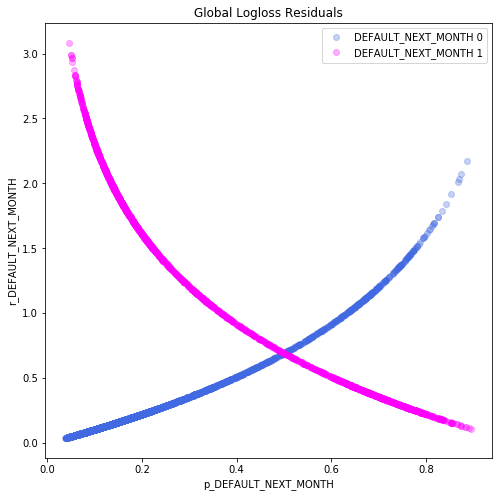

In [13]:
 # initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = valid_yhat_df.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, 
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(resid_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Some high-magnitude outlying residuals are visible. Who are these customers? Why is the model so wrong about them? And are they somehow exerting undue influence on other predictions? The model could be retrained without these individuals and retested as a potentially remediation strategy. 

#### Sort data by residuals and display data and residuals
Printing a table with model inputs, actual target values, and model predictions sorted by residuals is another simple way to analyze residuals. Customers that defaulted, but were predicted not to, are listed at the top of the table below. The next table contains customers who were predicted to default, but then did not. Also notice the jumps in residual values. These are the potential outliers pictured in the residual plot above. 

#### `DEFAULT_NEXT_MONTH = 1` residuals

In [14]:
valid_yhat_df1 = valid_yhat_df[valid_yhat_df[y_name] == 1]
valid_yhat_df1 = valid_yhat_df1.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
valid_yhat_df1.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,2561,310000,female,graduate school,single,32,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.045837,3.082662
1,3016,350000,male,graduate school,married,38,no consumption,no consumption,pay duly,use of revolving credit,use of revolving credit,no consumption,16459,4120,44164,35233,884,9924,941,44743,0,884,9924,10824,1,0.050230,2.991137
2,11462,210000,female,graduate school,single,46,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,15655,3918,29881,24247,21664,1556,4854,30366,0,433,1556,14047,1,0.050527,2.985238
3,25772,350000,female,graduate school,married,33,use of revolving credit,pay duly,pay duly,pay duly,pay duly,pay duly,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.051503,2.966110
4,6933,500000,male,graduate school,single,37,pay duly,pay duly,pay duly,pay duly,pay duly,pay duly,4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.051717,2.961960


#### `DEFAULT_NEXT_MONTH = 0` residuals

In [15]:
valid_yhat_df0 = valid_yhat_df[valid_yhat_df[y_name] == 0]
valid_yhat_df0 = valid_yhat_df0.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
valid_yhat_df0.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,5916,110000,female,graduate school,married,41,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,7 month delay,150,150,150,150,150,150,0,0,0,0,0,0,0,0.886468,2.175667
1,9672,170000,male,graduate school,single,48,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,7 month delay,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,0,0.874018,2.071614
2,22725,100000,female,university,married,38,3 month delay,2 month delay,2 month delay,3 month delay,3 month delay,3 month delay,750,750,750,750,750,750,0,0,0,0,0,1500,0,0.869051,2.032945
3,19316,110000,female,graduate school,married,41,3 month delay,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,150,150,150,150,150,150,0,0,0,0,0,0,0,0.866568,2.014160
4,29505,20000,male,university,married,40,1 month delay,2 month delay,3 month delay,2 month delay,3 month delay,3 month delay,14829,17267,16706,18694,19049,18459,3000,0,2560,955,0,661,0,0.852781,1.915832


This simple analysis has uncovered some of the most difficult customers for the GBM to correctly predict default. Perhaps because of the high importance of the payment variables, `PAY_0`-`PAY_6`, the GBM struggles to correctly predict several cases in which customers made timely recent payments and then suddenly defaulted and those customers that were chronically late making payments but did not default.

#### Plot residuals by most important input variable 
Residuals can also be plotted for important input variables to understand how the values of a single input variable affect prediction errors. When plotted by `PAY_0`, the residuals confirm that the GBM is struggling to accurately predict cases where default status is not correlated with recent payment behavior in an obvious way.

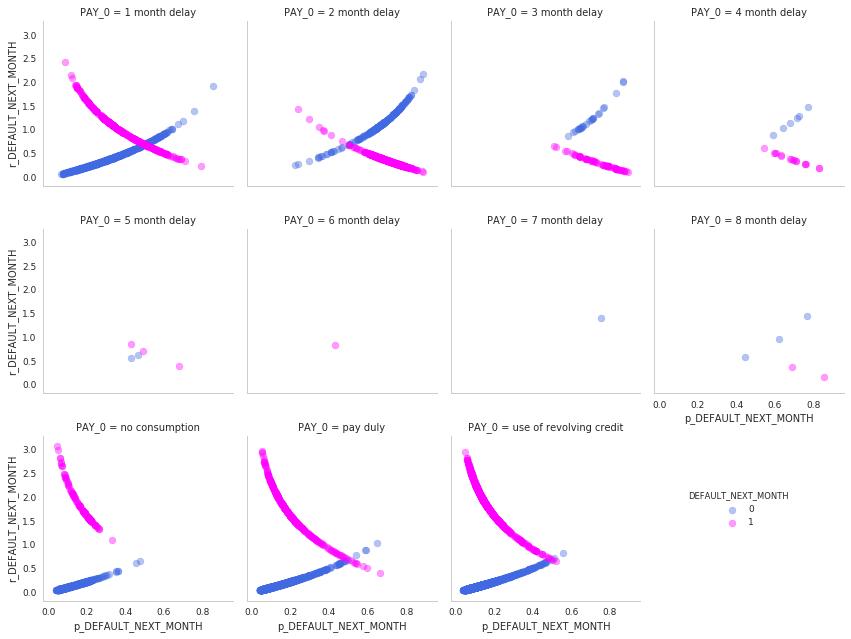

In [16]:
# use Seaborn FacetGrid for convenience
# some seaborn configs
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))      # consistent colors

# facet grid of residuals by PAY_0 
sorted_ = valid_yhat_df.sort_values(by='PAY_0')                 # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='PAY_0', hue=y_name, col_wrap=4) # init grid
_ = g.map(plt.scatter, yhat_name, resid_name, alpha=0.4)        # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

## 4. Retrain GBM Classifier Based on Results of Residual Analysis
Now that an issue has been discovered using residual analysis, can it be resolved? 

#### Create a variable that contains information about behavior over time
One strategy to improve prediction accuracy is to introduce a new variable that summarizes a customer's spending behavior over time to expose any potential financial instability: the standard deviation of a customer's bill amounts over six months.

In [17]:
data2 = data.as_data_frame()
data2['bill_std'] = data2[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)
data2.head(n=3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std
0,1,20000,female,university,married,24,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1761.633219
1,2,120000,female,university,single,26,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,637.967841
2,3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,6064.518593


#### Convert Pandas DataFrame back to H2OFrame for modeling

In [18]:
data2 = h2o.H2OFrame(data2)                          # convert 
data2[y_name] = data2[y_name].asfactor()             # ensure target is handled as a categorical variable
train2, valid2 = data2.split_frame([0.7], seed=SEED) # split into training and validation

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Retrain GBM with new variable

In [19]:
# initialize GBM model
gbm2 = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                    max_depth=6,           # trees can have maximum depth of 6
                                    sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                    col_sample_rate=0.85,  # use 90% of variables in each iteration (tree)
                                    stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                    seed=SEED)             # for reproducibility

# retrain GBM model
gbm2.train(y=y_name,
           x=x_names + ['bill_std'], # add new variable
           training_frame=train2, 
           validation_frame=valid2)

# print AUC
print('GBM Validation AUC = %.4f' % gbm2.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Validation AUC = 0.7825


While there maybe be other more complex variables or a more optimal set of hyperparameters that could lead to further incremental increases in accuracy, more information is needed to achieve meaningful improvement in prediction performance. In particular, a common measure for credit lending, the customers' debt-to-income ratio, for each payment and billing period could be particularly useful. Spikes in debt-to-income ratio, representing loss of income or large increases in debt, would likely be very indicative of a default and would expose the GBM to information not currently available in the UCI credit card default data. Introducing new data could also de-emphasize `PAY_0`, which would likely result in a more stable model as well.

## 5. Perform Sensitivity Analysis to Test Model Performance on Unseen Data

Sensitivity analysis investigates whether model behavior and outputs remain stable when data is intentionally perturbed or other changes are simulated in data. Beyond traditional assessment practices, sensitivity analysis of machine learning model predictions is perhaps the most important validation technique for machine learning models. Machine learning models can make drastically differing predictions for only minor changes in input variable values. 

Here sensitivity analysis is used to understand the impact of  changing the most important input variable, `PAY_0`, and the impact of a sociologically sensitive variable, `SEX`, in the model. If the model changes in reasonable and expected ways when important variable values are changed this can enhance trust in the model. If the contribution of potentially sensitive variables, such as those related to gender, race, age, marital status, or disability status, can be shown to have minimal impact on the model, this is an indication of fairness in the model predictions and can also increase overall trust in the model.

#### Bind new model predictions onto validation data 
Typically, a productive exercise in model debugging and validation is to investigate customers with very high or low predicted probabilities to determine if their predictions stay within reasonable bounds when important variables are changed. The predictions from the new, more accurate model are merged onto the validation set to find these potentially interesting customers. 

In [20]:
preds2 = gbm2.predict(valid2).drop(['predict', 'p0'])
preds2.columns = [yhat_name]
valid_yhat2 = valid2.cbind(preds2[yhat_name])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Find some percentiles of yhat in the validation data

In [21]:
pred_percentile_dict = explain.get_percentile_dict(yhat_name, valid_yhat2.as_data_frame(), 'ID')
pred_percentile_dict

{0: 14020,
 99: 25054,
 10: 1027,
 20: 21932,
 30: 6331,
 40: 24248,
 50: 18409,
 60: 22652,
 70: 19717,
 80: 9413,
 90: 23311}

#### Display validation data prediction range
Unlike some regression models and neural networks that can produce outrageous predictions for changes in input variables, GBM predictions in new data are bounded by the lowest and highest probability leaf nodes in each constiuent decision tree in the trained model. Extreme predictions are typically not an issue for tree models and classification tasks, but it is often a good idea to check that the model predictions cover a full range of useful values in the validation set.

In [22]:
print('Lowest prediction:', valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[0])][[y_name, yhat_name]])
print('Highest prediction:', valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[99])][[y_name, yhat_name]])

Lowest prediction: 

DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0,0.037913



Highest prediction: 

DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
1,0.90732


#### Use trained model to test predictions for interesting situations: customer least likely to default
As a starting point for further analysis, sensitivity analysis is performed for the customer least likely to default. This person has a very low probability of defaulting according to the trained GBM.

In [23]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[0])]
test_case

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,p_DEFAULT_NEXT_MONTH
14020,500000,male,university,married,42,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,114374,130999,153648,172515,178758,192589,50012,51343,70000,70000,80000,50000,0,29949.4,0.037913


#### Test effect of changing `SEX`

`SEX` should not have a large impact on predictions. This could indicate unwanted sociological bias in the GBM model.

In [24]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat_name])
test_case['SEX'] = 'female'
test_case = test_case.cbind(gbm2.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
14020,500000,female,university,married,42,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,114374,130999,153648,172515,178758,192589,50012,51343,70000,70000,80000,50000,0,29949.4,0,0.962739,0.037261


As desired, simulating this person as a different sex does not have a large impact on their probability of default.

#### Test effect of changing `PAY_0`

Variable importance and residual analysis indicates that the value of `PAY_0` can have a strong effect on model predictions. Measuring the change in predicted probability when the value of `PAY_0` is changed from a timely payment to late payment is probably a good test case for prediction stability. 

In [25]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat_name])
test_case['PAY_0'] = '2 month delay' 
test_case = test_case.cbind(gbm2.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
14020,500000,male,university,married,42,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,114374,130999,153648,172515,178758,192589,50012,51343,70000,70000,80000,50000,0,29949.4,1,0.410981,0.589019


When the value is changed to `two month delay` there is a very large increase in predicted probability. Such a marked change related to the value of one variable is problematic for numerous reasons.

#### Use trained model to test predictions for interesting situations: customer most likely to default
Now the same test will be performed on the customer most likely to default. This person has a very high probability of default under the GBM model. 

In [26]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[99])]
test_case

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,p_DEFAULT_NEXT_MONTH
25054,500000,male,graduate school,married,55,3 month delay,2 month delay,2 month delay,2 month delay,2 month delay,2 month delay,4957,4957,4957,4957,4957,4957,0,0,0,0,0,0,1,0,0.90732


#### Test effect of changing `SEX`
Changing the value for `SEX` for this customer changes the predicted probability by a relatively small amount.

In [27]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat_name])
test_case['SEX'] = 'female'
test_case = test_case.cbind(gbm2.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
25054,500000,female,graduate school,married,55,3 month delay,2 month delay,2 month delay,2 month delay,2 month delay,2 month delay,4957,4957,4957,4957,4957,4957,0,0,0,0,0,0,1,0,1,0.0919855,0.908015


#### Test effect of changing `PAY_0`
Switching the riskiest customer's value for `PAY_0` to `pay duly` reduces the their chance of default by a lot, a noticable swing in probability but still a higher probability value, notably greater than common lending cutoffs.

In [28]:
test_case = valid_yhat2[valid_yhat2['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat_name])
test_case['PAY_0'] = 'pay duly' 
test_case = test_case.cbind(gbm2.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
25054,500000,male,graduate school,married,55,pay duly,2 month delay,2 month delay,2 month delay,2 month delay,2 month delay,4957,4957,4957,4957,4957,4957,0,0,0,0,0,0,1,0,1,0.328214,0.671786


From this small number of boundary test cases, the GBM model appears stable. However, if large swings in predictions occur for sensitive or important variables, practicioners are urged to retrain unstable models without the problematic variables or combinations of variables, which may unfortunately involve some trial and error. Also, four test cases is woefully inadequate for real-world models. Automated sensitivity analysis across many variables, combinations of variables, and for many different rows of data seems more appropriate for mission-critical machine learning.

## 6. Benchmark Models
Benchmark models are an excellent model debugging tool. They can be used at training time to understand how a new model differs from an established, trusted model. They can also be used at scoring time to understand if a newer or more complex model is giving different predictions from a previously deployed trusted model or simpler model. If a prediction from a new model is too different from a prediction from a trusted model, this could be indicative of potential accuracy, fairness, or security problems.

#### Train a benchmark GLM 
Instead of using a pre-existing model, a stable penalized GLM will be used as a benchmark in this notebook.

In [29]:
best_glm = model.glm_grid(x_names + ['bill_std'], y_name, train2, valid2, SEED)
print('Best penalized GLM mean logloss residual: %.6f' % 
      best_glm.logloss(valid=True))
glm_cut = best_glm.F1(valid=True)[0][0] # get GLM cutoff to create decisions
print('At threshold: %.6f' % glm_cut)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Best penalized GLM mean logloss residual: 0.440206
At threshold: 0.246137


#### Find a comparable GBM cutoff

In [30]:
print('GBM mean logloss residual: %.6f' % 
      gbm2.logloss(valid=True))
gbm_cut = gbm2.F1(valid=True)[0][0] # get GBM cutoff to create decisions
print('At threshold: %.6f' % gbm_cut)

GBM mean logloss residual: 0.431708
At threshold: 0.227593


#### Find rows where GLM benchmark model is right, but GBM is wrong
One interesting place to start comparing a more complex model to a simpler model is when the simple model is right and the complex model is wrong.

In [31]:
# copy validation data
valid_yhat_df2 = valid_yhat2.as_data_frame().copy(deep=True)

# create columns for gbm and glm preds
valid_yhat_df2.rename(columns={yhat_name: 'p_gbm_DEFAULT_NEXT_MONTH'}, inplace=True)
valid_yhat_df2['p_glm_DEFAULT_NEXT_MONTH'] = best_glm.\
    predict(valid2)['p1'].\
    as_data_frame()

# create columns for gbm and glm decisions (i.e. apply cutoff)
valid_yhat_df2['gbm_DECISION'] = 0
valid_yhat_df2.loc[valid_yhat_df2['p_gbm_DEFAULT_NEXT_MONTH'] > gbm_cut,
                   'gbm_DECISION'] = 1
valid_yhat_df2['glm_DECISION'] = 0
valid_yhat_df2.loc[valid_yhat_df2['p_glm_DEFAULT_NEXT_MONTH'] > glm_cut,
                   'glm_DECISION'] = 1

# create columns for gbm and glm wrong decisions
valid_yhat_df2['gbm_WRONG'] = 0
valid_yhat_df2.loc[valid_yhat_df2[y_name] != valid_yhat_df2['gbm_DECISION'], 'gbm_WRONG'] = 1
valid_yhat_df2['glm_WRONG'] = 0
valid_yhat_df2.loc[valid_yhat_df2[y_name] != valid_yhat_df2['glm_DECISION'], 'glm_WRONG'] = 1

# create a subset of preds where gbm is wrong, but glm is right
gbm_wrong = valid_yhat_df2.loc[(valid_yhat_df2['gbm_WRONG'] == 1) & 
                               (valid_yhat_df2['glm_WRONG'] == 0)]

gbm_wrong[x_names + [y_name, 'p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH']].head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_glm_DEFAULT_NEXT_MONTH,p_gbm_DEFAULT_NEXT_MONTH
22,300000,female,graduate school,married,45,pay duly,pay duly,pay duly,pay duly,pay duly,pay duly,291,291,291,291,291,291,291,291,291,291,291,291,0,0.138724,0.234757
51,360000,male,graduate school,single,29,1 month delay,no consumption,pay duly,pay duly,no consumption,no consumption,0,0,77,0,0,0,0,77,0,0,0,0,0,0.203638,0.302616
65,50000,female,high school,single,37,1 month delay,3 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,52626,51537,49205,30394,30249,29957,0,24,1500,1000,1201,30592,1,0.356709,0.211182
80,10000,male,high school,single,23,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,6974,7838,9002,9182,9729,9411,1134,1298,478,847,0,175,0,0.182870,0.288847
92,440000,female,graduate school,single,36,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,0,0,0,0,0,0,0,0,0,0,162000,0,0,0.045490,0.298846


#### Plot rows where GLM benchmark model is right, but GBM is wrong

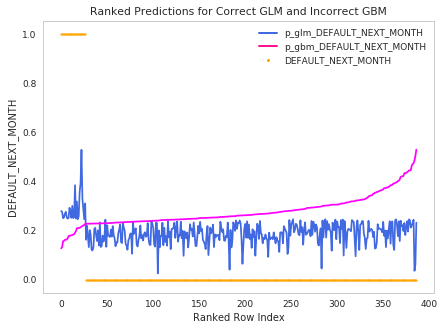

In [32]:
# custom legend
custom = [Line2D([0], [0], color='royalblue', lw=2),
          Line2D([0], [0], color='deeppink', lw=2),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='orange', markersize=3)]

# init plot
fig, ax = plt.subplots(figsize=(7, 5)) 

# plot sorted actuals
# double index reset orders index by sort variable and
# brings index into frame for plotting
_ = gbm_wrong[[y_name,'p_gbm_DEFAULT_NEXT_MONTH']].\
            sort_values(by='p_gbm_DEFAULT_NEXT_MONTH').\
            reset_index(drop=True).\
            reset_index().\
            plot(kind='scatter', x='index', y=y_name, color='orange', s=3, ax=ax, 
                 legend=False)

# plot sorted gbm and glm preds 
_ = gbm_wrong[['p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH']].\
            sort_values(by='p_gbm_DEFAULT_NEXT_MONTH').\
            reset_index(drop=True).\
            plot(ax=ax, legend=False, 
                 title='Ranked Predictions for Correct GLM and Incorrect GBM')

# annotate plot
_ = ax.legend(custom, ['p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH', 
                       y_name])
_ = ax.set_xlabel('Ranked Row Index')

For a range of probabilities between ~0.2 and ~0.6 there exists a group of customers where a GLM model gives more correct predictions than the more complex GBM model. In the plot above, the yellow points represent the known target labels, the pink line is the sorted GBM model predictions, and the blue line is the GLM predictions for the same customers and target labels. For this group of people the GLM is obviously able to better represent some attribute of the customer's demographics or behaviors. Can the differences between this group of people and the rest of the customers be identified and leveraged to make better predictions?

#### Descriptive statistics for rows where GLM benchmark model is right, but GBM is wrong

In [33]:
gbm_wrong.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,p_gbm_DEFAULT_NEXT_MONTH,p_glm_DEFAULT_NEXT_MONTH,gbm_DECISION,glm_DECISION,gbm_WRONG,glm_WRONG
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.0,387.0
mean,14074.307494,158010.335917,36.741602,24316.416021,24700.674419,25600.105943,24657.000000,22654.297158,20100.162791,2776.273902,2930.260982,1822.436693,2021.971576,1840.865633,5164.028424,0.069767,5190.572204,0.277158,0.193844,0.930233,0.069767,1.0,0.0
std,8475.155425,139110.497314,10.381101,70201.456042,69611.284225,70450.914928,67177.658606,60073.067598,53222.300942,8628.703418,12493.251481,6093.907597,8385.120506,9212.506376,35502.730094,0.255084,15358.965587,0.060774,0.050228,0.255084,0.255084,0.0,0.0
min,78.000000,10000.000000,21.000000,-1580.000000,-5978.000000,-2400.000000,-1580.000000,-1773.000000,-2303.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127516,0.025709,0.000000,0.000000,1.0,0.0
25%,7060.000000,40000.000000,29.000000,131.500000,190.500000,281.000000,117.000000,102.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,192.360136,0.238541,0.165909,1.000000,0.000000,1.0,0.0
50%,13531.000000,130000.000000,35.000000,1727.000000,1516.000000,1300.000000,1430.000000,1072.000000,1060.000000,896.000000,526.000000,318.000000,390.000000,390.000000,390.000000,0.000000,1072.610025,0.261236,0.194743,1.000000,0.000000,1.0,0.0
75%,20920.500000,235000.000000,44.000000,12399.000000,14646.000000,15993.000000,17049.500000,17728.000000,15733.500000,2284.000000,2000.000000,1273.000000,1108.000000,1000.000000,1500.000000,0.000000,2557.592732,0.302298,0.225916,1.000000,0.000000,1.0,0.0
max,29951.000000,680000.000000,67.000000,568532.000000,577681.000000,577957.000000,565669.000000,524315.000000,476846.000000,100082.000000,200000.000000,80167.000000,135000.000000,162000.000000,443001.000000,1.000000,184306.178369,0.529573,0.528843,1.000000,1.000000,1.0,0.0


If this group of people can be isolated, either by descriptive statistics, or by more sophisticated means, the training process could be adapted to fix these errors or another model could be used at scoring time to create more accurate predictions. Even if a group cannot be isolated, the two different model predictions could potentially be blended in this range of predicted probabilities.

#### Shutdown H2O

In [34]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_abf7 closed.
